# Downscaling GADM28 countries and also building continent-level shapes

The [Wilmap](http://dev-wilmap.pantheonsite.io/map) project requires us to construct two javascript files of downscaled polygons for countries, and continents. These shapes must match exactly. The continents must follow the [continent definition](https://en.wikipedia.org/wiki/Boundaries_between_the_continents_of_Earth) that divides Europe and Aisia and North and South America.

Currently the wilmap map is generated from two JS files (found in `wilmap/themes/wilmap_theme/dist/source`) of the [project repo](https://github.com/Vizzuality/wilmap), a continent file which is used to render the land-surface, and a country file which is used to paint white lines as borders between them. However, there is a problem in that these shapes have been created in an incompatible way. It looks like currently there were to seperate sources as the orginal shapefiles, which were both simplified to a similar degree. However, the shapefiles were not identical, and consequently the simplification has produced different results. Now the map has an issue in relation to polygon overlap. We need to create new version that are identical at both the country and continent level.



## Procedure

1. Read Admin-0 and Russia Admin-1 shapefiles of GADM28
2. Collapse Russia into two areas (East and West based on continent definition that includes Europe and Aisa)
3. Add the new shapes to a modified version of the admin-0 shapefile (also dump un-needed attributes from the table) and export as a shapefile.
    * Also we will need to address a bug with the shapefile at this level wherein South Sudan (and possibly more) countries are missing ISO codes. These should be added to the modified version of the file.
4. Upload the exported shapefile to [MapShaper](http://mapshaper.org/) and simplify the polygons to the desired level, export the simplified data as a shapefile.
5. Import the simplified data back to the notebook, add a column which defines the desired continent grouping of the country shape:
    * Take care to **not assign Russia**, but to instead assign the east and west divisions you created of Russia to the appropriate continent category.
    * There are also a couple of countries we have noted that you will also need possibly take extra care are correctly assigned, e.g. Cuba, Jamaica. 
6. Use the new column to dissolve the shapefile e.g. `continets = admin0_simplified_shapes.dissolve(by='continent_labels') `
7. Write out both the simplified country shapes and the continent shapes to JSON files. Remove the custom created russian area shapes from the country files after writing, also add in the javascript variable syntax of the original files.


### Resources

* [GADM28 website](http://www.gadm.org/)
* [GADM28 - Russia shapefile](http://www.gadm.org/download)
* [Wilmap API (returns list of continent definitions with countries)](http://dev-wilmap.pantheonsite.io/api/map/browse)



#### Notes
1. What shapes should be in each file? We can answer this question using the Wilmap API link above:
    * We have used these data to construct a dictionary to label the continents of each country shape.
1. The attributes which should be on the shapes for each of the files: 
    * Country file:
        'geometry' + name_engli, iso2, unregion2 (these attributes are directly from the original GAMD28 file)
    * Continent file:
        geometry + 'CONTINENT' {'Africa', 'Asia', 'Central America', 'Europe', 'North America',
       'Oceania', 'South America'}
2. Missing countries are present in the file with a `null` field as the geometry attribute.


## 1. Read and deal with original data

In [1]:
import geopandas as gpd
import numpy as np
from iso3166 import countries 
%matplotlib inline

In [16]:
gpd.__version__

'0.2.1'

In [13]:
# You will need to uncompress the countries shapefile first

!ls ./data/gadm28_countries.zip

./data/gadm28_countries.zip


In [14]:
original_gadm28 = gpd.read_file('./data/gadm28_countries/gadm28_countries.shp')

In [15]:
original_gadm28.head()

,area_ha,bbox,cartodb_id,centroid,contains,developing,geometry,id_0,islands,iso,...,unregion1,unregion2,validfr,validto,waspartof,wbdebt,wbincome,wbother,wbregion,www
0,3.247209e+07,"{""type"":""Polygon"",""coordinates"":[[[-9.11742102...",169,"{""type"":""Point"",""coordinates"":[15.409599070085...",None,2.0,(POLYGON ((7.576389789581356 57.98847198486345...,169,0.0,NOR,...,Northern Europe,Europe,19050607,Present,None,Debt not classified,High income: OECD,None,None,None
1,1.797044e+02,None,231,None,None,1.0,POLYGON ((-171.786392211914 -9.147776603698617...,231,1.0,TKL,...,Polynesia,Oceania,Unknown,Present,None,None,None,None,None,None
2,5.140220e+07,"{""type"":""Polygon"",""coordinates"":[[[97.35140100...",228,"{""type"":""Point"",""coordinates"":[101.00333319808...",None,1.0,(POLYGON ((99.31054687500011 6.487649917602539...,228,0.0,THA,...,South-Eastern Asia,Asia,Unknown,Present,None,Less indebted,Lower middle income,None,East Asia & Pacific,None
3,9.123939e+07,"{""type"":""Polygon"",""coordinates"":[[[-73.3911486...",249,"{""type"":""Point"",""coordinates"":[-66.16883923189...",None,1.0,(POLYGON ((-60.64263916015619 8.68402767181390...,249,0.0,VEN,...,South America,Americas,1830,Present,None,Moderately indebted,Upper middle income,None,Latin America & Caribbean,None
4,9.085410e+07,"{""type"":""Polygon"",""coordinates"":[[[2.671081990...",163,"{""type"":""Point"",""coordinates"":[8.0912395825427...",None,1.0,(POLYGON ((6.095695018768311 4.356805801391829...,163,0.0,NGA,...,Western Africa,Africa,19601001,Present,None,Moderately indebted,Low income,None,Sub-Saharan Africa,None


In [17]:
# Find unique fields in a column
#original_gadm28['unregion1'].unique()

array(['Northern Europe', 'Polynesia', 'South-Eastern Asia',
       'South America', 'Western Africa', 'Northern Africa',
       'Southern Asia', 'Western Europe', 'Northern America', 'Melanesia',
       'Australia and New Zealand', None, 'Central America', 'Caribbean',
       'Eastern Asia', 'Southern Europe', 'Middle Africa', 'Western Asia',
       'Eastern Europe', 'Antartica', 'Micronesia', 'Eastern Africa',
       'Southern Africa', 'Central Asia'], dtype=object)

In [19]:
# Method of masking an array based on a logical test, and then calling a view on the masked array for a specific column

mask_region = original_gadm28['unregion2'] == 'Americas'
original_gadm28[mask_region]['iso2']

3        VE
5        AR
8        BR
12       US
18       MX
19       CL
25       BB
26       CA
36       PM
39       DM
40       KN
42       CU
49       AI
65       GF
75       AW
76     None
78     None
80       GL
84       BO
86       SV
87       GD
94       SR
97       FK
116      TT
117      LC
119      PR
133      TC
134    None
135      JM
138      AN
140      BZ
141      KY
142      AG
143      VC
148      HN
158      BM
160      HT
161      CR
163      DO
165      EC
168      NI
174      GY
175      PY
176      VG
193      PE
196      MS
197      CO
202      VI
208      GP
217      GT
223      BS
230      UY
236      MQ
241      PA
Name: iso2, dtype: object

In [ ]:
# Way of seeing the keys (columns) in a geopandas dataframe
original_gadm28.keys()

In [22]:
# rough example of the concept necessary to build the continents from the country file:
# Way of creating a copy of a dataframe and reducing the columns present, then show how to unify by a column

world = original_gadm28[["name_engli","iso2","unregion2",'unregion1', 'geometry']] # shallow copy?
continents = world.dissolve(by='unregion2')  # joining shapes based on an attribute column - can make this a country shape thing
continents.head()

,geometry,name_engli,iso2,unregion1
unregion2,,,,
Africa,(POLYGON ((-9.973054885864258 -40.273334503173...,Nigeria,NG,Western Africa
Americas,(POLYGON ((-67.32360839843727 -55.918750762939...,Venezuela,VE,South America
Antartica,(POLYGON ((-69.43698120117188 -76.491149902343...,Antarctica,AQ,Antartica
Asia,(POLYGON ((122.8673248291018 -10.9656839370725...,Thailand,TH,South-Eastern Asia
Europe,(POLYGON ((-17.92791748046875 27.8495826721191...,Norway,NO,Northern Europe


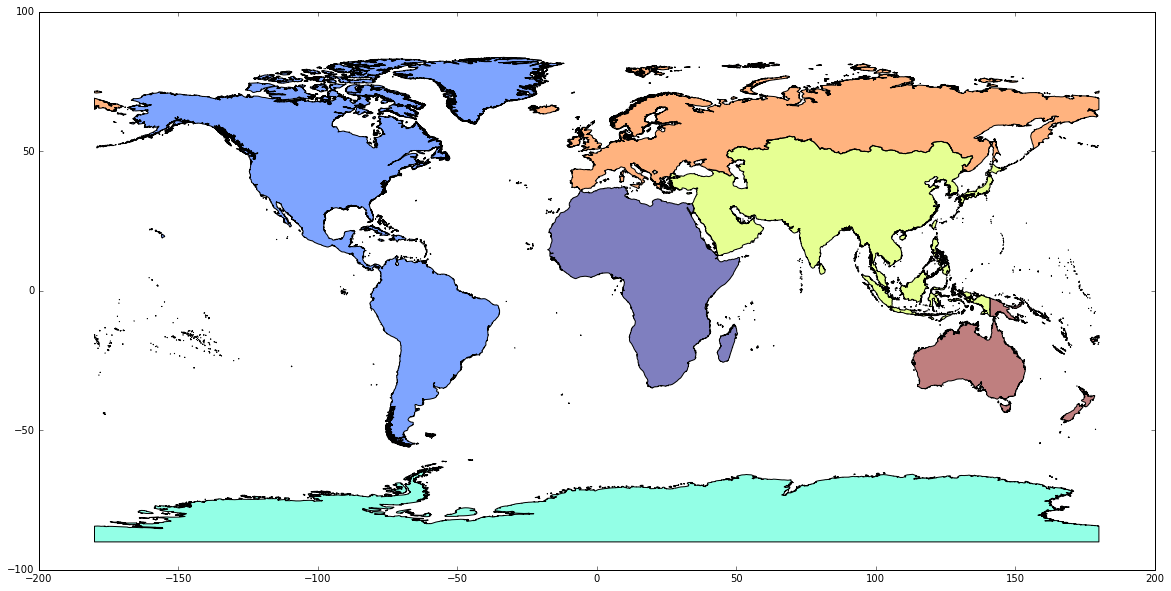

In [23]:
continents.plot(figsize=(20,20))

In [ ]:
world.plot()

In [ ]:
world.keys()

In [ ]:
# example of how to save the new file as shapefiles, first make a target directory
#!mkdir .data/stripped_gadm28

In [ ]:
# then use the geopandas to_file method to write out good shapes as a shapefile
#world.to_file(driver = 'ESRI Shapefile', filename = '.data/stripped_gadm28/stripped_gadm28.shp')

### Fix  South Sudan missing country code

In [ ]:
simplified_countries = gpd.read_file("./stripped_gadm28/stripped_gadm28.shp")

In [ ]:
simplified_countries.head()

In [ ]:
mask_ss = simplified_countries['name_engli'] == 'South Sudan'
simplified_countries[mask_ss]

In [ ]:
simplified_countries['name_engli'][155]

In [ ]:
new_iso_codes = simplified_countries['iso2'].values

In [ ]:
new_iso_codes[155] = 'SS'

In [ ]:
simplified_countries['iso2'] = new_iso_codes

In [ ]:
!mkdir ./fixed_simple_countries

In [ ]:
simplified_countries.to_file(driver = 'ESRI Shapefile', filename = './fixed_simple_countries/fixed_simple_countries.shp"')

## You will need to create a full-reslution country shapefile with Russia (split into east and west) before you proceede


## Next, the Mapshaper simplification stage

## Read fixed shapefile, and add column for continents

Note the Wilmap menu must become the source of truth for which country is in which continents. If you look you will see that there are many issues, for example Kosovo is missing, Austrailia is not included in Oceana correctly. These should be fixed.

I.e. if there is a country listed, it should have a shape. And if a country is listed within an area, it should highlight on mouse-over.

In [ ]:
simplified_countries = gpd.read_file('./fixed_simple_countries/fixed_simple_countries.shp')

In [ ]:
simplified_countries.head()

In [ ]:
# dictionary of countries: continents



In [ ]:
C_to_c = {"Africa": ["DZ","AO","BJ","BW","BF","BI","CM","CV","CF","TD","KM","CD","DJ","GQ","EG","ER","ET",
            "GA","GM","GH","GN","GW","CI","KE","LS","LR","LY","MG","MW","ML","MR","MU","YT",
            "MA","MZ","NA","NE","NG","CG","RE","RW",
            "SH","ST","SN","SC","SL","SO","ZA","SS","SD","SZ","TZ","TG","TN","UG","EH","ZM","ZW"],
 "Asia": ["AF","AM","AZ","BH","BD","BT","IO","BN","KH","CN","CX","CC","CY","TL","GE",
          "HK","IN","ID","IR","IQ","IL","JP","JO","KZ","KW","KG","LA","LB","MO","MY","MV",
          "MN","MM","NP","KP","OM","PK","PS","PH","QA","SA","SG","KR","LK","SY","TW","TJ","TH",
          "TR","TM","AE","UZ","VN","YE"],
"Central America": ["BZ","CR","SV","GT","HN","NI","PA"],
"Europe": ["AL","AD","AT","BY","BE","BA","BG","XX","HR","CZ","DK","EE","FO","FI","FR","DE",
             "GI","GR","HU","IS","IE","IT","XK","LV","LI","LT","LU","MK","MT","MD","MC","ME","NL","NO",
             "PL","PT","RO","RU","SM","RS","SK","SI","ES","SJ","SE","CH","UA","GB","VA"],
"North America": ["BM","CA","GL","MX","PM","US"],
"Oceania": ["AS","AU","CK","FJ","PF","GU","KI","MH","FM","NR","NC","NZ","NU","NF","MP",
 "PW","PG","PN","WS","SB","TK","TO","TV","UM","VU","WF"],
"South America": ["AR","BO","BR","CL","CO","EC","FK","GF","GY","PY","PE","SR","UY","VE"]}


d = {}
for key in C_to_c.keys():
    for c in C_to_c[key]:
        d[c] = key

In [ ]:
countries.get('Egypt')

In [ ]:
len(simplified_countries)

In [ ]:
continent_id = []
for n, iso in enumerate(simplified_countries.iso2):
#    if iso == None and simplified_countries.geometry[n] != None:
#         try:
#             print(simplified_countries['name_engli'][n], countries.get(simplified_countries['name_engli'][n]).alpha2)
#         except:
#             print(f"nothing found for {simplified_countries['name_engli'][n]}")
    try:
        if iso in ['JM','CU']:
            print(f'True for {iso}')
            continent_id.append("North America")            
        else:
            continent_id.append(d[iso])
    except:
        continent_id.append(None)

simplified_countries['continent_key'] = continent_id
simplified_countries.head() #[np.array(continent_id) == None]

We need to mask out the missing shapes now, including shapes not assigned to continents, and also rows without any valid geometry

In [ ]:
mask_out_nones = simplified_countries['continent_key'] != None
tmp_ = simplified_countries[mask_out_nones]

In [ ]:
mask_for_geoms = tmp_.geometry.values != None
tmp_2 = tmp_[mask_for_geoms]

In [ ]:
continents = tmp_2.dissolve(by='continent_key')  # joining shapes based on an attribute column - can make this a country shape thing
continents.head()

In [ ]:
continents.plot(figsize=[20,20])

In [ ]:
!mkdir fixed_continents

In [ ]:
!ls

In [ ]:
continents.to_file(driver = 'ESRI Shapefile', filename = 'fixed_continents/fixed_continents.shp')

In [ ]:
continents

We need to make the continent name heading as such and drop all other columns before exporting to json:

"CONTINENT":"North America"

In [ ]:
c_tmp_labels = continents.index.values
c_tmp_geoms = continents.geometry.values

In [ ]:
c_tmp_labels

In [ ]:
trimmed_continent_output = gpd.GeoDataFrame(c_tmp_labels, columns=['CONTINENT'], geometry=c_tmp_geoms)
trimmed_continent_output.head()

In [ ]:
js_string = trimmed_continent_output.to_json()

with open('./fixed_continents.js', 'w') as f:
    f.write(js_string)

#### Possible hanging problems of note

Looks like the existing product doesnt deal with the shapes for:

delete:
    Northern Cyrpus
    Kosovo
    

In [ ]:
# Output shapefile as jsons (for later)

json_string = simplified_countries.to_json

with open('./new_countries.json', 'w') as f:
    f.write(json_string)